In [1]:
# !pip install nltk
# !pip install pandas
# !pip install numpy
# import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
# # !pip install ipython-autotime

# # %load_ext autotime

In [2]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from num2words import num2words
from collections import Counter
from sklearn.manifold import TSNE

import nltk
import os
import string
import numpy as np
import copy
import pandas as pd
import pickle
import math
import matplotlib.pyplot as plt

In [3]:
title = "20_newsgroups"

In [4]:
paths = []
for (dirpath, dirnames, filenames) in os.walk(str(os.getcwd())+'/'+title+'/rec.motorcycles'):
    for i in filenames:
        paths.append(str(dirpath)+str("/")+i)
for (dirpath, dirnames, filenames) in os.walk(str(os.getcwd())+'/'+title+'/comp.graphics'):
    for i in filenames:
        paths.append(str(dirpath)+str("/")+i)

In [5]:
len(paths)

2000

In [6]:
def print_doc(id):
    file = open(paths[id], 'r', encoding='cp1250')
    text = file.read().strip()
    file.close()
    print(text)

In [7]:
def convert_numbers(k):
    for i in range(len(k)):
        try:
            k[i] = num2words(int(k[i]))
        except:
            pass
    return k

In [8]:
def doc_freq(word):
    c = 0
    try:
        c = DF[word]
    except:
        pass
    return c

In [9]:
def cosine_sim(a, b):
    cos_sim = np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
    return cos_sim

In [10]:
def preprocess(pd):
    pd = pd.str.lower()
    pd = pd.str.replace('[{}]'.format('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~\n\t'), ' ')
    pd = pd.apply(lambda x: [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(x)])
    pd = pd.apply(lambda x: convert_numbers(x))
    pd = pd.str.join(' ')
    pd = pd.str.replace('[{}]'.format(string.punctuation), ' ')
    
    pd = pd.apply(lambda x: [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(x)])    
    pd = pd.apply(lambda x: [item for item in x if item not in stop_words])
    pd = pd.apply(lambda x: [stemmer.stem(y) for y in x])
    return pd

In [11]:
stop_words = stopwords.words('english')

In [12]:
lemmatizer = nltk.stem.WordNetLemmatizer()
stemmer = nltk.stem.PorterStemmer()
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()

In [13]:
doc = 0
docs = []

for path in paths:
    file = open(path, 'r', encoding='cp1250')
    text = file.read().strip()
    file.close()
    
    docs.append(text)
    
    if doc%700 == 0:
        print(doc)
        
    doc += 1
docs_pd = pd.DataFrame(docs)
docs_pd[0] = preprocess(docs_pd[0])

0
700
1400


In [15]:
DF = {}

n = 0
for tokens in docs_pd[0]:
    for w in tokens:
        try:
            DF[w].add(n)
        except:
            DF[w] = {n}
    n += 1
for i in DF:
    DF[i] = len(DF[i])

In [16]:
doc = 0
N = docs_pd.shape[0]
tf_idf = {}

for tokens in docs_pd[0]:
    
    counter = Counter(tokens)
    words_count = len(tokens)
    
    for token in np.unique(tokens):
        
        tf = counter[token]/words_count
        df = doc_freq(token)
        idf = np.log((N+1)/(df+1))
        
        tf_idf[doc, token] = tf*idf

    doc += 1

In [17]:
total_vocab_size = len(DF)
total_vocab = [x for x in DF]

In [18]:
D = np.zeros((N, total_vocab_size))
for i in tf_idf:
    try:
        ind = total_vocab.index(i[1])
        D[i[0]][ind] = tf_idf[i]
    except:
        pass

In [19]:
D.shape

(2000, 20787)

In [20]:
def gen_vector(tokens):

    Q = np.zeros((len(total_vocab)))
    
    counter = Counter(tokens)
    words_count = len(tokens)

    query_weights = {}
    
    for token in np.unique(tokens):
        
        tf = counter[token]/words_count
        df = doc_freq(token)
        idf = math.log((N+1)/(df+1))

        try:
            ind = total_vocab.index(token)
            Q[ind] = tf*idf
        except:
            pass
    return Q

In [21]:
def calc_centroid(doc_ids):
    vec = [D[i] for i in doc_ids]
    return np.array(vec).sum(axis=0)/len(doc_ids)

In [66]:
def get_cosines(Q):
    d_cosines = []
    co = 0
    for d in D:
        if co not in used_docs:
            d_cosines.append(cosine_sim(Q, d))
        co += 1
    out = np.array(d_cosines).argsort()[-10:][::-1]
    return list(out)

In [109]:
def get_feedback(out):
    
    for i in range(len(out)):
        print(i, out[i])

    n_rel = input("Enter Non Relevant Docs: ").split(" ")
    
    nr_docs = [out[int(i)] for i in n_rel]
    r_docs = list(set(out)-set(nr_docs))
    
    return r_docs, nr_docs

In [130]:
def gen_tsne(Q_r, Q_nr, Q_m):
    tsne = TSNE(n_components=2, random_state=0)

    feature_vector = []
    labels = []

    for i in Q_r:
        feature_vector.append(D[i])
        labels.append(0)
    for i in Q_nr:
        feature_vector.append(D[i])
        labels.append(1)

    feature_vector.append(Q_m)
    labels.append(2)

    transformed_data = tsne.fit_transform(np.array(feature_vector))
    k = np.array(transformed_data)
    t = ("Relevant", "Non Relevant", "Query")
    plt.scatter(k[:, 0], k[:, 1], c=labels, s=60, alpha=0.8, label="Violet-R, Aqua-NR")
    plt.title("Rocchio Algorithm")
    plt.legend()
    plt.grid(True)
    plt.show()


Iteration 0
<class 'set'>
0 1360
1 1657
2 1574
3 483
4 1326
5 1046
6 1359
7 1307
8 465
9 59
Enter Non Relevant Docs: 1 4 6 7
{1360, 465, 483, 1574, 1046, 59} {1657, 1307, 1326, 1359}


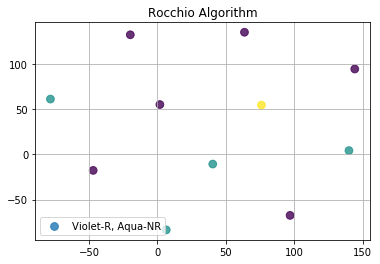


Iteration 1
0 1137
1 1542
2 1246
3 754
4 1558
5 1893
6 1697
7 1019
8 515
9 947
Enter Non Relevant Docs: 9 8 7
{1697, 483, 1893, 1574, 1542, 1360, 465, 1137, 754, 1046, 1558, 59, 1246} {515, 947, 1019, 1657, 1307, 1326, 1359}


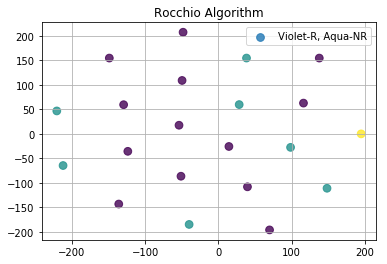


Iteration 2
0 994
1 514
2 1001
3 1535
4 1240
5 1206
6 1971
7 1688
8 1550
9 1015
Enter Non Relevant Docs: 9
{514, 1542, 1550, 1360, 465, 1046, 1558, 1688, 1240, 1246, 1697, 994, 483, 1893, 1574, 1001, 1137, 754, 1971, 1206, 59, 1535} {515, 947, 1015, 1019, 1657, 1307, 1326, 1359}


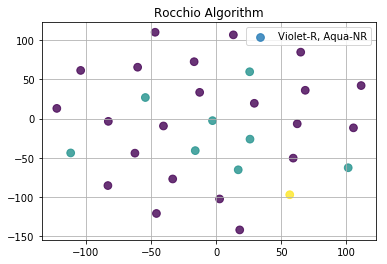


Iteration 3
0 992
1 998
2 513
3 1961
4 1201
5 1234
6 1542
7 582
8 376
9 1895
Enter Non Relevant Docs: 9
{513, 514, 1542, 582, 1550, 1360, 465, 1234, 1046, 1558, 1688, 1240, 1246, 992, 1697, 994, 483, 1893, 1574, 998, 1001, 1961, 1137, 754, 1971, 1201, 1206, 376, 59, 1535} {515, 1895, 1326, 1359, 1307, 947, 1015, 1657, 1019}


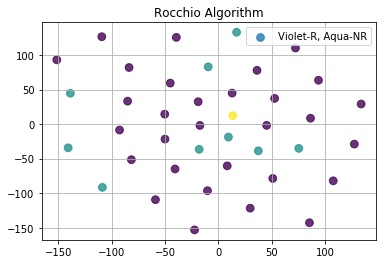


Iteration 4
0 987
1 993
2 511
3 1887
4 1013
5 579
6 1524
7 560
8 70
9 530
Enter Non Relevant Docs: 9
{513, 514, 1542, 511, 1550, 1046, 1558, 1688, 1697, 1574, 1961, 560, 1201, 1971, 1206, 59, 579, 582, 70, 1360, 465, 1234, 1240, 987, 1246, 1887, 992, 993, 994, 483, 1893, 998, 1001, 1137, 754, 1524, 1013, 376, 1535} {515, 1895, 1326, 1359, 1307, 530, 947, 1015, 1657, 1019}


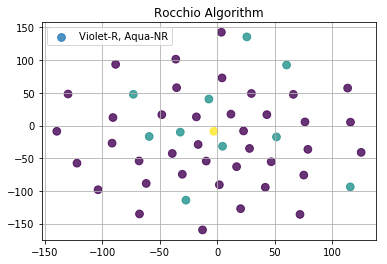


Iteration 5
0 980
1 986
2 509
3 1005
4 1877
5 574
6 586
7 556
8 1646
9 1515


In [ ]:
query_history = {}
used_docs = []

def run_query(count, alpha, beta, gamma, question, used_docs):

    tokens = preprocess(pd.DataFrame([question])[0])
    Q = gen_vector(list(tokens)[0])

    for i in range(count):
        print("\nIteration", i)

        if hash(question) in query_history:

            q_his = query_history[hash(question)]

            Q_r, Q_nr, Q_old = q_his[0], q_his[1], q_his[2]

            Q_m = (alpha*Q_old) + (beta*calc_centroid(Q_r)) - (gamma*calc_centroid(Q_nr))

        else:
            Q_m = Q
            Q_r = set()
            Q_nr = set()
            print(type(Q_nr))
            
        retrieved_docs = get_cosines(Q_m)
        
        k = get_feedback(retrieved_docs)

        Q_r = Q_r | set(k[0])
        Q_nr = Q_nr | set(k[1])
        
        used_docs += Q_r
        used_docs += Q_nr

        print(Q_r, Q_nr)

        gen_tsne(Q_r, Q_nr, Q_m)

        query_history[hash(question)] = [Q_r, Q_nr, Q_m]

    
question = "I don't know what kind of machine you want it for, but the program Radiance comes with 'C' source"
run_query(10, 0.5, 0.3, 0.2, question, used_docs)